In [ ]:
%load_ext autoreload
%load_ext autotime

time: 187 µs (started: 2024-12-12 22:25:44 -08:00)


In [2]:
import os
import sys
import time
import warnings
from bokeh.io import output_notebook

# Add WisIO to the path
sys.path.append(os.path.abspath("../"))

# Filter warnings
warnings.filterwarnings('ignore')

# Set the notebook to display Bokeh plots
output_notebook()

Loading BokehJS ...

time: 676 ms (started: 2024-12-12 22:25:44 -08:00)


In [3]:
analyzer = "dftracer"

run_dir = f".wisio/{analyzer}/{int(time.time())}"
bottleneck_dir = f"{run_dir}/bottlenecks"
checkpoint_dir = f"{run_dir}/checkpoints"

cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:46423"

checkpoint = False
exclude_characteristics = ['node_count', 'app_count', 'proc_count', 'file_count']
logical_view_types = False
percentile = 0.95
time_granularity = 1e6
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/cm1/APP/node-1/v1/RAW/*.pfw.gz"

app_metrics = [
    'intensity',
    'io_compute_per',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    'time_norm',
    'time_per',
    # 'u_checkpoint_io_time',
    # 'u_io_time_per',
    # 'u_read_io_time',
]
dataloader_metrics = [
    'intensity',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]
posix_metrics = [
    'intensity',
    'data_bw',
    'data_time_norm',
    'data_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]

app_view_types = ['proc_name', 'time_range']
dataloader_view_types = ['proc_name', 'time_range']
posix_view_types = ['proc_name', 'time_range']

time_view_type = 'time_range'
unoverlapped_posix_only = False

output_compact = False
output_group_behavior = False
output_max_bottlenecks = 1
output_root_only = True


time: 1.49 ms (started: 2024-12-12 22:25:45 -08:00)


In [4]:

# Parameters
analyzer = "dftracer"
bottleneck_dir = "/p/lustre3/iopp/wisio-bottlenecks/dftracer-resnet50-dlio-v100-node-16-v3-proc_name-time_range"
checkpoint = True
checkpoint_dir = "/p/lustre3/iopp/wisio-checkpoints/dftracer-resnet50-dlio-v100-node-16-v3-proc_name-time_range"
cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:38171"
logical_view_types = False
output_max_bottlenecks = 3
output_root_only = False
percentile = 0.9
run_dir = ".wisio/dftracer-resnet50-dlio-v100-node-16-v3-proc_name-time_range"
time_granularity = 2000000.0
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/resnet50/dlio-v100/node-16/v3/COMPACT/*.pfw.gz"

app_view_types = ["proc_name", "time_range"]
dataloader_view_types = ["proc_name", "time_range"]
posix_view_types = ["proc_name", "time_range"]



time: 1.06 ms (started: 2024-12-12 22:25:50 -08:00)


In [5]:
from distributed import Client
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from hydra.utils import instantiate
from wisio.cluster import ExternalCluster
from wisio.config import init_hydra_config_store
from wisio.utils.file_utils import ensure_dir

ensure_dir(run_dir)

with initialize(version_base=None, config_path=None):
    init_hydra_config_store()
    cfg = compose(
        config_name="config",
        overrides=[
            f"+analyzer={analyzer}",
            f"analyzer.bottleneck_dir={bottleneck_dir}",
            f"analyzer.checkpoint={checkpoint}",
            f"analyzer.checkpoint_dir={checkpoint_dir}",
            f"analyzer.time_granularity={time_granularity}",
            # f"cluster={cluster}",
            # f"cluster.restart_on_connect={cluster_restart_on_connect}",
            # f"cluster.scheduler_address={cluster_scheduler_address}",
            "cluster=external",
            "cluster.scheduler_address=tcp://127.0.0.1:46065",
            f"exclude_characteristics=[{','.join(exclude_characteristics)}]",
            f"hydra.run.dir={run_dir}",
            f"hydra.runtime.output_dir={run_dir}",
            f"logical_view_types={logical_view_types}",
            f"output.compact={output_compact}",
            f"output.group_behavior={output_group_behavior}",
            f"output.max_bottlenecks={output_max_bottlenecks}",
            f"output.root_only={output_root_only}",
            f"percentile={percentile}",
            f"trace_path={trace_path}",
        ],
        return_hydra_config=True,
    )
    HydraConfig.instance().set_config(cfg)
    cluster = instantiate(cfg.cluster)
    if isinstance(cluster, ExternalCluster):
        client = Client(cluster.scheduler_address)
        if cluster.restart_on_connect:
            client.restart()
    else:
        client = Client(cluster)
    analyzer = instantiate(cfg.analyzer)
    output = instantiate(cfg.output)

time: 3.19 s (started: 2024-12-12 22:26:01 -08:00)


In [6]:
client.dashboard_link

'http://127.0.0.1:8787/status'

time: 6.45 ms (started: 2024-12-12 22:26:04 -08:00)


In [7]:
client.restart()

<Client: 'tcp://127.0.0.1:46065' processes=4 threads=4>

time: 3.35 s (started: 2024-12-12 22:26:04 -08:00)


In [8]:
from wisio.constants import Layer

result = analyzer.analyze_trace(
    trace_path=cfg.trace_path,
    bottleneck_rules=cfg.bottleneck_rules,
    exclude_bottlenecks=cfg.exclude_bottlenecks,
    exclude_characteristics=cfg.exclude_characteristics,
    logical_view_types=cfg.logical_view_types,
    percentile=cfg.percentile,
    metrics={
        'dlio': app_metrics,
        'compute': app_metrics,
        'dataloader': dataloader_metrics,
        'image': dataloader_metrics,
        'reader': dataloader_metrics,
        'checkpoint': dataloader_metrics,
        'posix': posix_metrics,
    },
    time_view_type=time_view_type,
    unoverlapped_posix_only=unoverlapped_posix_only,
    view_types={
        'dlio': app_view_types,
        'compute': app_view_types,
        'dataloader': dataloader_view_types,
        'image': dataloader_view_types,
        'reader': dataloader_view_types,
        'checkpoint': dataloader_view_types,
        'posix': posix_view_types,
    },
)

time: 1min 29s (started: 2024-12-12 22:26:07 -08:00)


In [9]:
traces, hlms, main_views, metric_boundaries, views, flat_views = result

time: 526 µs (started: 2024-12-12 22:27:37 -08:00)


In [11]:
checkpoint_dir

'/p/lustre3/iopp/wisio-checkpoints/dftracer-resnet50-dlio-v100-node-16-v3-proc_name-time_range'

time: 2.15 ms (started: 2024-12-12 22:27:42 -08:00)


In [12]:
traces.to_parquet(f"{checkpoint_dir}/_traces", write_metadata_file=True)

time: 3.79 s (started: 2024-12-12 22:27:43 -08:00)


In [10]:
from dask.distributed import wait

persisted_traces = traces.persist()
wait(persisted_traces)

DoneAndNotDoneFutures(done={<Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-c28659e478b41e17d378858fab718287', 8)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-c28659e478b41e17d378858fab718287', 17)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-c28659e478b41e17d378858fab718287', 18)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-c28659e478b41e17d378858fab718287', 26)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-c28659e478b41e17d378858fab718287', 21)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-c28659e478b41e17d378858fab718287', 13)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-c28659e478b41e17d378858fab718287', 10)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-c28659e478b41e17d378858fab718287', 16)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-c28659e478b41e17d378858fab718287'

time: 1.69 s (started: 2024-12-02 10:15:05 -08:00)


In [11]:
persisted_traces.query('time_range == 27')['func_name'].value_counts().compute()

func_name
pread                    35584
<module>.iter             1280
<module>.yield            1280
TFFramework.compute       1280
TFReader._parse_image     1280
Name: count, dtype: int64[pyarrow]

time: 429 ms (started: 2024-12-02 10:15:06 -08:00)


In [12]:
persisted_traces.query('time_range == 28')['func_name'].value_counts().compute()

func_name
pread                    39168
<module>.iter             1280
<module>.yield            1280
TFFramework.compute       1280
TFReader._parse_image     1280
open                      1024
close                      256
Name: count, dtype: int64[pyarrow]

time: 122 ms (started: 2024-12-02 10:15:07 -08:00)


In [13]:
persisted_traces.query('time_range == 29')['func_name'].value_counts().compute()

func_name
pread                    3072
close                    1024
TFFramework.compute       128
TFReader._parse_image     128
write                       4
Name: count, dtype: int64[pyarrow]

time: 117 ms (started: 2024-12-02 10:15:07 -08:00)


In [14]:
persisted_traces.query('time_range == 33')['func_name'].value_counts().compute()

func_name
ConfigArguments.build_sample_map_iter    252
ConfigArguments.reconfigure              128
TFDataLoader.finalize                    128
write                                      1
Name: count, dtype: int64[pyarrow]

time: 116 ms (started: 2024-12-02 10:15:07 -08:00)


In [15]:
persisted_traces.query('time_range == 34')['func_name'].value_counts().compute()

func_name
pread                                    73472
TFReader._parse_image                     2560
<module>.iter                             1280
<module>.yield                            1280
TFFramework.compute                       1280
open                                      1024
__fxstat64                                 256
lseek64                                    256
read                                       256
TFDataLoader.next                          128
__xstat64                                  128
close                                      128
open64                                     128
ConfigArguments.build_sample_map_iter        4
write                                        3
Name: count, dtype: int64[pyarrow]

time: 113 ms (started: 2024-12-02 10:15:07 -08:00)


In [10]:
flat_views[('time_range',)].sort_index().to_csv('resnet50_node16_time_range.csv')

time: 58.5 ms (started: 2024-12-08 09:05:40 -08:00)


In [11]:
flat_views[('proc_name',)].sort_index().to_csv('resnet50_node16_proc_name.csv')

time: 3.09 s (started: 2024-12-08 09:05:41 -08:00)


In [12]:
flat_views[('proc_name', 'host_name')].sort_index().to_csv('resnet50_node16_host_name.csv')

time: 34 ms (started: 2024-12-08 09:05:44 -08:00)


In [13]:
flat_views[('proc_name', 'proc_id')].sort_index().to_csv('resnet50_node16_proc_id.csv')

time: 59.2 ms (started: 2024-12-08 09:05:44 -08:00)


In [26]:
import pandas as pd

df3 = pd.read_csv('resnet50_node16_proc_name.csv')

time: 272 ms (started: 2024-12-02 11:37:17 -08:00)


In [14]:
flat_views[('time_range',)][
    [
        'dlio_time',
        'compute_time',
        'dataloader_time',
        'image_time',
        'reader_time',
        'posix_time',
        'checkpoint_time',
        'u_dataloader_time',
        'u_image_time',
        'u_reader_time',
        'u_posix_time',
        'u_checkpoint_time',
    ]
].sum()

dlio_time            153.850604
compute_time         152.290957
dataloader_time        1.551605
image_time                  0.0
reader_time            0.750226
posix_time             6.422795
checkpoint_time         0.25515
u_dataloader_time      1.551605
u_image_time                0.0
u_reader_time               0.0
u_posix_time           2.734226
u_checkpoint_time       0.25515
dtype: double[pyarrow]

time: 5.72 ms (started: 2024-12-08 09:06:00 -08:00)


<Axes: >

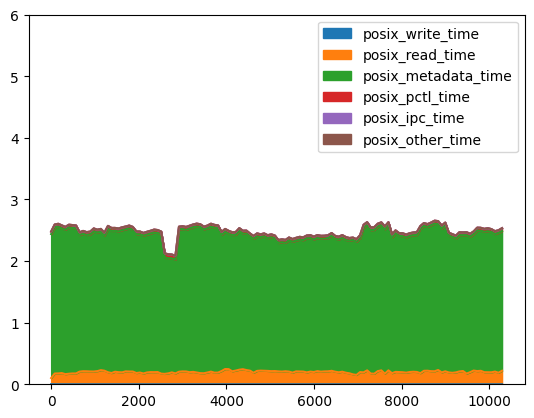

time: 242 ms (started: 2024-12-02 11:38:24 -08:00)


In [29]:
df3.query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_time',
        # 'dlio_stall_time',
        # 'checkpoint_time',
        # 'dataloader_time',
        # 'reader_time',
        # 'dataloader_sample_time',
        # 'posix_time',
        'posix_write_time',
        'posix_read_time',
        'posix_metadata_time',
        'posix_pctl_time',
        'posix_ipc_time',
        'posix_other_time',
    ]
].plot(kind='area', ylim=(0, 6))

<Axes: xlabel='time_range'>

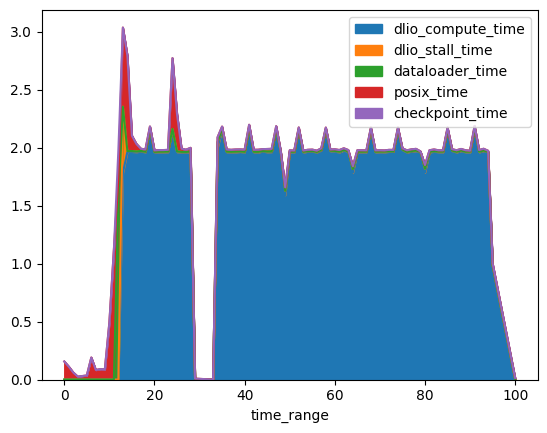

time: 882 ms (started: 2024-12-08 09:06:35 -08:00)


In [16]:
flat_views[('time_range',)][
    [
        'dlio_compute_time',
        'dlio_stall_time',
        # 'compute_time',
        'dataloader_time',
        # 'image_time',
        # 'reader_time',
        'posix_time',
        'checkpoint_time',
        # 'u_dataloader_time',
        # 'u_image_time',
        # 'u_reader_time',
        # 'u_posix_time',
        # 'u_checkpoint_time',
    ]
].plot(kind='area')

<Axes: >

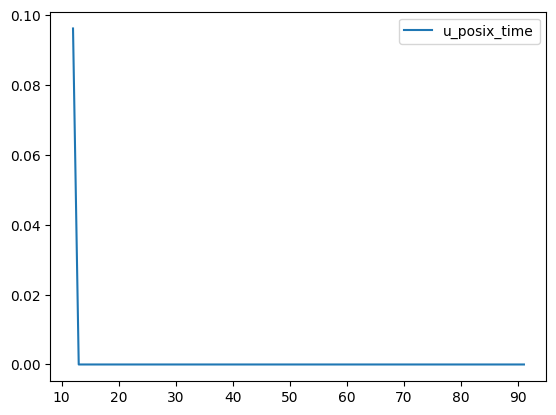

time: 244 ms (started: 2024-12-02 10:15:12 -08:00)


In [23]:
pd.read_csv('resnet50_node16_time_range.csv').query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_util',
        # 'dlio_stall_time',
        # 'checkpoint_time',
        # 'dataloader_time',
        # 'reader_time',
        # 'dataloader_sample_time',
        'u_posix_time',
    ]
].plot()

<Axes: >

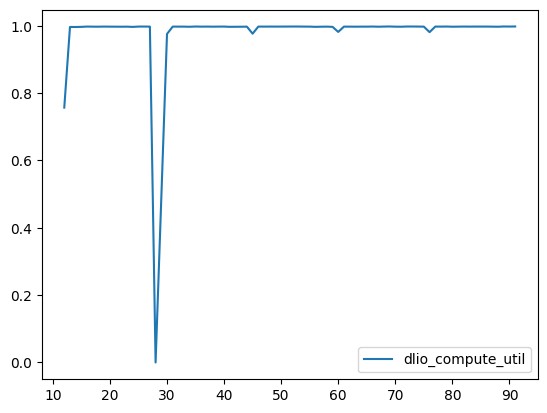

time: 201 ms (started: 2024-12-02 10:24:00 -08:00)


In [25]:
pd.read_csv('resnet50_node16_time_range.csv').query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_util',
        # 'dlio_stall_time',
        # 'checkpoint_time',
        # 'dataloader_time',
        # 'reader_time',
        # 'dataloader_sample_time',
        # 'posix_time',
    ]
].plot()

In [20]:
import pandas as pd 
from wisio.metrics import set_metric_scores

time_range_view = pd.read_csv('resnet50_node16_time_range.csv').copy().set_index('time_range')
# time_range_view = pd.read_csv('cosmoflow_node4_proc_name.csv').copy().set_index('proc_name')
time_range_view.index = time_range_view.index.astype(str)

time_range_view['reader_r3_time'] = time_range_view['reader_time'].rolling(window=3).mean()
time_range_view['reader_r3_gauss_time'] = time_range_view['reader_time'].rolling(window=3, win_type='gaussian').mean(std=1)
time_range_view['reader_r3_hann_time'] = time_range_view['reader_time'].rolling(window=3, win_type='hann').mean()

time_range_view['reader_r3_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_r3_time'].sum()
time_range_view['reader_r3_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_r3_gauss_time'].sum()
time_range_view['reader_r3_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_r3_hann_time'].sum()

time_range_view['reader_r3_2_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_time'].sum()

time_range_view['reader_r3_time_norm'] = time_range_view['reader_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_gauss_time_norm'] = time_range_view['reader_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_hann_time_norm'] = time_range_view['reader_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

time_range_view['posix_read_r3_time'] = time_range_view['posix_read_time'].rolling(window=10).sum()
time_range_view['posix_read_r3_gauss_time'] = time_range_view['posix_read_time'].rolling(window=10, win_type='gaussian').sum(std=1)
time_range_view['posix_read_r3_hann_time'] = time_range_view['posix_read_time'].rolling(window=10, win_type='hann').sum()

time_range_view['posix_read_r3_time_per'] = time_range_view['posix_read_r3_time'] / time_range_view['posix_read_r3_time'].sum()
time_range_view['posix_read_r3_gauss_time_per'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view['posix_read_r3_gauss_time'].sum()
time_range_view['posix_read_r3_hann_time_per'] = time_range_view['posix_read_r3_hann_time'] / time_range_view['posix_read_r3_hann_time'].sum()

time_range_view['posix_read_r3_time_norm'] = time_range_view['posix_read_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_gauss_time_norm'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_hann_time_norm'] = time_range_view['posix_read_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

# time_range_view['dlio_compute_util'] = time_range_view['dlio_compute_time'].astype(
#     float
# ) / (
#     time_range_view['dlio_compute_time'].astype(float)
#     + time_range_view['dlio_stall_time'].astype(float)
#     # + time_range_view['checkpoint_time'].astype(float)
# )

time_range_view = set_metric_scores(time_range_view)
# time_range_view['dlio_compute_util_score'] = 8 - time_range_view['dlio_compute_util_score']
# time_range_view['dlio_compute_util_score'] = time_range_view['dlio_compute_util_score'].mask(time_range_view['dlio_compute_time'] == 0, pd.NA)

dlio_cols = ['dlio_compute_util_score'] # [col for col in time_range_view.columns if 'dlio_' in col and col.endswith('_score')]
dataloader_cols = [col for col in time_range_view.columns if 'dataloader_' in col and col.endswith('_score')and col.endswith('_score')]
checkpoint_cols = [col for col in time_range_view.columns if 'checkpoint_' in col and col.endswith('_score')]
posix_cols = [col for col in time_range_view.columns if 'posix_' in col and col.endswith('_score')]
# norm_cols = [col for col in time_range_view.columns if '_score' in col]
# norm_cols = ['dlio_compute_util_score'] + norm_cols
norm_cols = dlio_cols + dataloader_cols + checkpoint_cols + posix_cols

norm_cols = [col for col in norm_cols if 'slope' not in col]

norm_scores = time_range_view[norm_cols]
norm_scores

,dlio_compute_util_score,dataloader_bw_score,dataloader_count_per_score,dataloader_intensity_score,dataloader_ops_rank_score,dataloader_sample_time_norm_score,dataloader_sample_time_per_score,dataloader_time_norm_score,dataloader_time_per_score,u_dataloader_sample_time_norm_score,...,u_posix_read_time_norm_score,u_posix_read_time_per_score,u_posix_seek_time_norm_score,u_posix_seek_time_per_score,u_posix_stat_time_norm_score,u_posix_stat_time_per_score,u_posix_time_norm_score,u_posix_time_per_score,u_posix_write_time_norm_score,u_posix_write_time_per_score
time_range,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,1,3,1,2,1,3,1,3,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,2,1,2,1,3,1,3,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,2,0,0,1,1,1,3,1,5
3,0,0,0,0,0,0,0,0,0,0,...,1,3,0,0,1,2,1,2,1,5
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 219 ms (started: 2024-12-08 09:07:45 -08:00)


In [21]:
import pandas as pd

norm_scores_all = norm_scores.copy()
for col in norm_cols:
    norm_scores2 = norm_scores.copy()
    norm_scores2['score_col'] = col
    norm_scores2['score'] = norm_scores2[col]
    norm_scores_all = pd.concat([norm_scores_all, norm_scores2])
norm_scores_all.drop(columns=norm_cols).dropna()

,score_col,score
time_range,,
0,dlio_compute_util_score,0
1,dlio_compute_util_score,0
2,dlio_compute_util_score,0
3,dlio_compute_util_score,0
5,dlio_compute_util_score,0
...,...,...
92,u_posix_write_time_per_score,0
93,u_posix_write_time_per_score,0
94,u_posix_write_time_per_score,0


time: 1.66 s (started: 2024-12-08 09:07:46 -08:00)


In [22]:
from math import pi

import pandas as pd

from bokeh.models import BasicTicker, PrintfTickFormatter
from bokeh.plotting import figure, show
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import linear_cmap
from bokeh.palettes import RdYlGn, Reds, TolYlOrBr
from bokeh.io import output_notebook

output_notebook()


VAL_COL = 'proc_id'

years = list(time_range_view.index.astype(str))
months = list(reversed(norm_cols))

# reshape to 1D array or rates with a month and year for each row.
df = norm_scores_all.drop(
    columns=norm_cols
).reset_index().dropna()  # pd.DataFrame(data.stack(), columns=['rate']).reset_index()

# this is the colormap from the original NYTimes plot
colors = [
    "#75968f",
    "#a5bab7",
    "#c9d9d3",
    "#e2e2e2",
    "#dfccce",
    "#ddb7b1",
    "#cc7878",
    "#933b41",
    "#550b1d",
]
mapper = linear_cmap(
    field_name="score",
    palette=Reds[8][::-1],  # Green-to-Red palette with 11 steps
    low=0,
    high=8,
)

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(
    # title=f"US Unemployment ({years[0]} - {years[-1]})",
    x_range=years,
    y_range=months,
    x_axis_location="above",
    width=900,
    height=400,
    tools=TOOLS,
    toolbar_location='below',
    tooltips=[('date', '@time_range'), ('score', '@score%')],
)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3

r = p.rect(
    x="time_range",
    y="score_col",
    width=1,
    height=1,
    source=df,
    fill_color=mapper, # linear_cmap("score", colors, low=0, high=8),
    line_color=None,
)

p.add_layout(
    r.construct_color_bar(
        major_label_text_font_size="7px",
        ticker=BasicTicker(desired_num_ticks=len(colors)),
        formatter=PrintfTickFormatter(format="%d%%"),
        label_standoff=6,
        border_line_color=None,
        padding=5,
    ),
    'right',
)

show(p)

Loading BokehJS ...

time: 127 ms (started: 2024-12-08 09:07:48 -08:00)


In [7]:
output.handle_result(metrics=cfg.metrics, result=result)

╭────────────────────────────────────────────── I/O Characteristics ──────────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime          202.68 seconds                                                                                │
│  I/O Time         2.56 seconds                                                                                  │
│                   ├── Read - 1.41 seconds (55.26%)                                                              │
│                   ├── Write - 0.00 seconds (0.08%)                                                              │
│                   └── Metadata - 2.33 seconds (90.89%)                                                          │
│  I/O Operations   11,640,839 ops                                                                                │
│                   ├── Read - 3,214,719 ops (27.62%)                                                             │
│                   ├── Write - 4,022 ops (0.03%)                                                                 │
│                   └── Metadata - 8,386,770 ops (72.05%)                                                         │
│  I/O Size         727.93 GiB                                                                                    │
│                   ├── Read - 727.93 GiB (100.00%)                                                               │
│                   └── Write - 179.65 kiB (0.00%)                                                                │
│  Read Requests    4 kiB-256 kiB - 3,214,136 ops                                                                 │
│                   ├── <4 kiB - 175,232 ops (5.45%)                                                              │
│                   ├── 4-16 kiB - 20,032 ops (0.62%)                                                             │
│                   ├── 16-64 kiB - 31,353 ops (0.98%)                                                            │
│                   └── 64-256 kiB - 2,987,519 ops (92.95%)                                                       │
│  Write Requests   4 kiB-4 kiB - 4,022 ops                                                                       │
│                   └── <4 kiB - 4,022 ops (100.00%)                                                              │
│  Nodes            16 nodes                                                                                      │
│                   ├── 11194065546293973417 - 2.56 s (100.00%) - 45.50 GiB/10.56 kiB R/W (6.25/0.00%) - 727,549  │
│                   │   ops (6.25%)                                                                               │
│                   ├── 784840397337378243 - 2.54 s (99.38%) - 45.50 GiB/10.56 kiB R/W (6.25/0.00%) - 727,548     │
│                   │   ops (6.25%)                                                                               │
│                   ├── 13943161580101246997 - 2.52 s (98.25%) - 45.50 GiB/10.56 kiB R/W (6.25/0.00%) - 727,559   │
│                   │   ops (6.25%)                                                                               │
│                   ├── 12775585946864612109 - 2.49 s (97.46%) - 45.50 GiB/21.21 kiB R/W (6.25/0.00%) - 727,609   │
│                   │   ops (6.25%)                                                                               │
│                   ├── 17424505939907203644 - 2.46 s (96.29%) - 45.50 GiB/10.56 kiB R/W (6.25/0.00%) - 727,547   │
│                   │   ops (6.25%)                                                                               │
│                   ├── 3331529830307220231 - 2.46 s (96.17%) - 45.50 GiB/10.56 kiB R/W (6.25/0.00%) - 727,552    │
│                   │   ops (6.25%)                                                                               │
│                   ├── 3903101653980564509 - 2.46 s (96

time: 8.64 s (started: 2024-10-14 10:47:31 -07:00)
